In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from skimage import io
from os.path import expanduser
from tqdm import tqdm
HOME = expanduser("~")
import os
import cv2
import skimage.exposure
import pandas as pd

In [2]:
#DIR = os.path.join(HOME, 'programming', 'dk39')
DIR = '/net/birdstore/Active_Atlas_Data/data_root/pipeline_data/MD589'
INPUT = os.path.join(DIR, 'preps', 'CH1', 'thumbnail')
#INPUT = os.path.join(DIR, 'tif')
OUTPUT = os.path.join(DIR, 'preps', 'masked')
files = sorted(os.listdir(INPUT))

In [4]:
# convert to hsv
def flood(img, colors):
    # convert to hsv
    hsv = cv2.cvtColor(img,cv2.COLOR_BGR2HSV)

    # threshold using inRange
    if sum(colors) > 100:
        range1 = (80,80,80)
        range2 = (93,93,93)
    else:
        range1 = (0,0,0)
        range2 = (3,3,3)
        
    mask = cv2.inRange(hsv,range1,range2)
    mask = 255 - mask

    # apply morphology opening to mask
    kernel = np.ones((3,3), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_ERODE, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    # antialias mask
    mask = cv2.GaussianBlur(mask, (0,0), sigmaX=3, sigmaY=3, borderType = cv2.BORDER_DEFAULT)
    mask = skimage.exposure.rescale_intensity(mask, in_range=(127.5,255), out_range=(0,255))

    result = img.copy()
    result[mask==0] = colors
    return result



def place_image(img, file, max_width, max_height):
    zmidr = max_height // 2
    zmidc = max_width // 2
    startr = zmidr - (img.shape[0] // 2)
    endr = startr + img.shape[0]
    startc = zmidc - (img.shape[1] // 2)
    endc = startc + img.shape[1]

    start_bottom = img.shape[0] - 5
    bottom_rows = img[start_bottom:img.shape[0], :]
    avg = np.mean(bottom_rows)
    bgcolor = int(round(avg))

    new_img = np.zeros([max_height, max_width]) + bgcolor
    try:
        new_img[startr:endr, startc:endc] = img
    except:
        print('could not create new img', file)

    return new_img.astype('uint16')



def find_main_blob(stats, image):
    height, width = image.shape
    df = pd.DataFrame(stats)
    df.columns = ['Left', 'Top', 'Width', 'Height', 'Area']
    df['blob_label'] = df.index
    df = df.sort_values(by='Area', ascending=False)

    for row in df.iterrows():
        Left = row[1]['Left']
        Top = row[1]['Top']
        Width = row[1]['Width']
        Height = row[1]['Height']
        corners = int(Left == 0) + int(Top == 0) + int(Width == width) + int(Height == height)
        if corners <= 2:
            return row


def scale_and_mask(src, mask, epsilon=0.01):
    vals = np.array(sorted(src[mask > 10]))
    ind = int(len(vals) * (1 - epsilon))
    _max = vals[ind]
    #print('ind {} _max {}'.format(ind, _max))
    _range = 2 ** 8 - 1
    scaled = src * (190. / _max)
    scaled[scaled > _range] = _range
    scaled = scaled * (mask > 80)
    return scaled, _max



def find_threshold(src):
    fig = matplotlib.figure.Figure()
    ax = matplotlib.axes.Axes(fig, (0, 0, 0, 0))
    n, bins, patches = ax.hist(src.flatten(), 16);
    del ax, fig
    min_point = np.argmax(n[:12])
    #min_point = int(min(2, min_point))
    thresh = (min_point * 18)
    return min_point, thresh


def find_thresholdDark(src):
    fig = matplotlib.figure.Figure()
    ax = matplotlib.axes.Axes(fig, (0, 0, 0, 0))
    n, bins, patches = ax.hist(src.flatten(), 16);
    del ax, fig
    min_point = np.argmin(n[:5])
    min_point = int(max(2, min_point))
    thresh = (min_point * 255 / 8 + 40)
    return min_point, thresh

In [ ]:
dels = os.listdir(OUTPUT)
for d in dels:
    os.unlink(os.path.join(OUTPUT, d))

In [7]:
bads = ['0125.tif', '0118.tif']

In [8]:
# get oriented for comparison
img_inputs = []
img_outputs = []
file_inputs = []
titles = []
masks = []
max_width = 1400
max_height = 900
for i, file in enumerate(tqdm(bads)):
    infile = os.path.join(INPUT, file)
    src = io.imread(infile)
    #src = src[:, :, 0]
    #clahe = cv2.createCLAHE(clipLimit=40.0, tileGridSize=(16,16))
    #src = clahe.apply(src)

    min_value, threshold = find_threshold(src)
    #src = place_image(src, file, max_width, max_height)

    img_inputs.append(src)
    file_inputs.append(file)
    #threshold = 20
    titles.append([min_value,threshold])

    ret, threshed = cv2.threshold(src, threshold, 255, cv2.THRESH_BINARY)
    threshed = np.uint8(threshed)
    ###### Find connected elements
    # You need to choose 4 or 8 for connectivity type
    connectivity = 4
    output = cv2.connectedComponentsWithStats(threshed, connectivity, cv2.CV_32S)
    # Get the results
    # The first cell is the number of labels
    num_labels = output[0]
    # The second cell is the label matrix
    labels = output[1]
    # The third cell is the stat matrix
    stats = output[2]
    # The fourth cell is the centroid matrix
    centroids = output[3]
    # Find the blob that corresponds to the section.
    row = find_main_blob(stats, src)
    blob_label = row[1]['blob_label']
    
    # extract the blob
    blob = np.uint8(labels == blob_label) * 255
    # Perform morphological closing
    kernel10 = np.ones((10, 10), np.uint8)
    closing = cv2.morphologyEx(blob, cv2.MORPH_CLOSE, kernel10, iterations=5)
    scaled, _max = scale_and_mask(src, closing)
    #scaled[scaled >= 190] = 0
    #scaled = place_image(scaled, file, max_width, max_height)

    
    # repeat mask on scaled #################
    #min_value, threshold = 2,50
    min_value, threshold = find_thresholdDark(scaled)

    #threshold = 80
    ret, threshed = cv2.threshold(scaled, threshold, 255, cv2.THRESH_BINARY)
    threshed = np.uint8(threshed)
    ###### Find connected elements
    # You need to choose 4 or 8 for connectivity type
    connectivity = 4
    output = cv2.connectedComponentsWithStats(threshed, connectivity, cv2.CV_32S)
    # Get the results
    # The first cell is the number of labels
    num_labels = output[0]
    # The second cell is the label matrix
    labels = output[1]
    # The third cell is the stat matrix
    stats = output[2]
    # The fourth cell is the centroid matrix
    centroids = output[3]
    # Find the blob that corresponds to the section.
    row = find_main_blob(stats, scaled)
    blob_label = row[1]['blob_label']
    # extract the blob
    blob = np.uint8(labels == blob_label) * 255
    # Perform morphological closing
    kernel10 = np.ones((10, 10), np.uint8)
    closing2 = cv2.morphologyEx(blob, cv2.MORPH_CLOSE, kernel10, iterations=5)
    
    img_outputs.append(scaled)

    #closing = place_image(closing2, file, max_width, max_height)
    masks.append(closing2)
    outpath = os.path.join(OUTPUT, file)    
    #cv2.imwrite(outpath, closing2.astype('uint8'))
print('Finished')

100%|██████████| 2/2 [00:00<00:00,  6.51it/s]

Finished


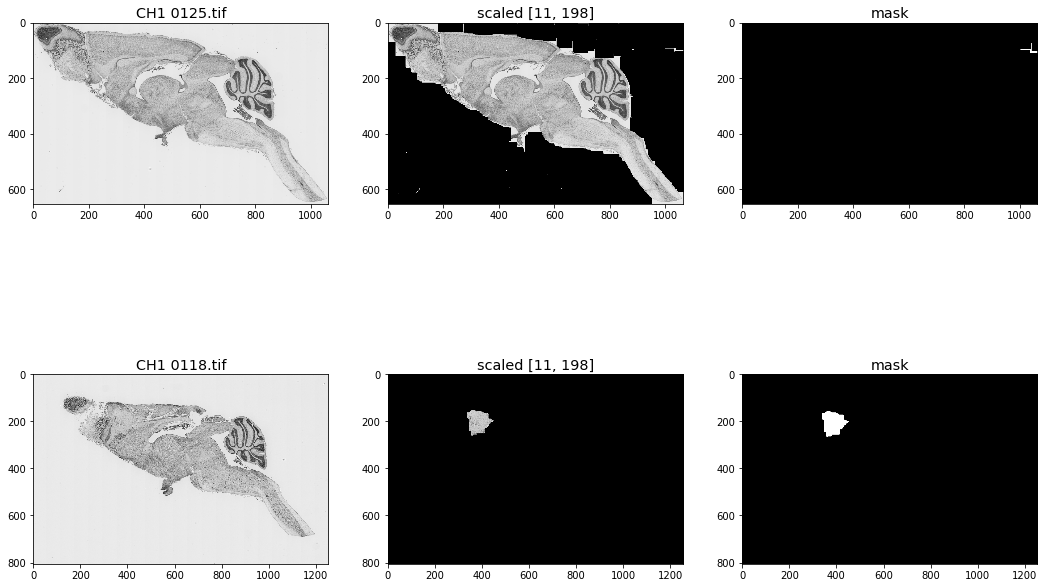

In [9]:
start, finish = (0,10)
#displays = masks[start:finish]
dins = img_inputs[start:finish]
douts = img_outputs[start:finish]
dmasks = masks[start:finish]
dtitles = titles[start:finish]
names = file_inputs[start:finish]

fig, ax = plt.subplots(nrows=len(names), ncols=3, sharex=False)
plt.style.use('classic')
i = 0
for filein,fileout, mask,name,title in zip(dins, douts, dmasks, names, dtitles):
    ax[i,0].set_title('CH1 {}'.format(name))
    ax[i,0].imshow(filein, cmap="gray")
    ax[i,1].set_title('scaled {}'.format(str(title)))
    ax[i,1].imshow(fileout, cmap="gray")
    ax[i,2].set_title('mask')
    ax[i,2].imshow(mask, cmap="gray")

    i += 1
# swap the 10 and the six below if the images are wider than height
fig.set_size_inches(np.array([18, 6 * len(names)]), forward=True)
plt.show()

ind 6417 _max 248


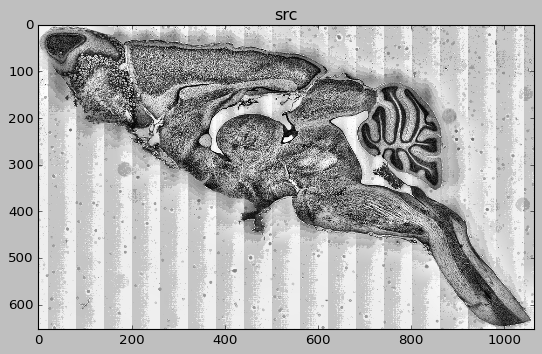

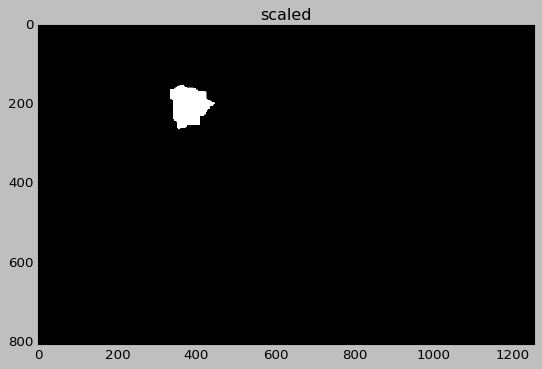

In [11]:
infile = os.path.join(INPUT, '0125.tif')
src = io.imread(infile)
#src = src[:, :, 0]
#clahe = cv2.createCLAHE(clipLimit=40.0, tileGridSize=(16,16))
#src = clahe.apply(src)

min_value, threshold = find_threshold(src)
#threshold = 120
ret, threshed = cv2.threshold(src, threshold, 255, cv2.THRESH_BINARY)
threshed = np.uint8(threshed)
connectivity = 4
output = cv2.connectedComponentsWithStats(threshed, connectivity, cv2.CV_32S)
num_labels = output[0]
labels = output[1]
stats = output[2]
centroids = output[3]
row = find_main_blob(stats, src)
#print(row)
blob_label = row[1]['blob_label']
blob = np.uint8(labels == blob_label) * 255
kernel10 = np.ones((10, 10), np.uint8)
mask = cv2.morphologyEx(blob, cv2.MORPH_CLOSE, kernel10, iterations=5)
#scaled, _max = scale_and_mask(src, closing)
epsilon = 0.1
vals = np.array(sorted(src[mask > 10]))
ind = int(len(vals) * (1 - epsilon))
_max = vals[ind]
print('ind {} _max {}'.format(ind, _max))
_range = 2 ** 8 - 1
scaled = src * (190. / _max)
scaled = place_image(scaled, '0125', 1400, 900)
mask = place_image(mask, '0125', 1400, 900)

scaled[scaled > _range] = _range
scaled = scaled * (mask == 0)

plt.figure()
plt.rcParams.update({'figure.figsize': [8, 6]})
plt.title('src')
plt.imshow(src, cmap='gray')
plt.show()

plt.figure()
plt.rcParams.update({'figure.figsize': [8, 6]})
plt.title('scaled')
plt.imshow(closing, cmap='gray')
plt.show()

